In [1]:
#Se cargan los diferentes paquetes necesarios
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import numpy as np 

In [2]:
#Se carga la data usando la libreria pandas
data = pd.read_csv('Data_fraude.csv')

In [3]:
#Se utiliza head para observar como se ven las observaciones
print(data.head(10))

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815      170136.00       160296.36   
1     1   PAYMENT   1864.28  C1666544295       21249.00        19384.72   
2     1  TRANSFER    181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT    181.00   C840083671         181.00            0.00   
4     1   PAYMENT  11668.14  C2048537720       41554.00        29885.86   
5     1   PAYMENT   7817.71    C90045638       53860.00        46042.29   
6     1   PAYMENT   7107.77   C154988899      183195.00       176087.23   
7     1   PAYMENT   7861.64  C1912850431      176087.23       168225.59   
8     1   PAYMENT   4024.36  C1265012928        2671.00            0.00   
9     1     DEBIT   5337.77   C712410124       41720.00        36382.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0            0.00        0               0  
1  M2044282225            

In [4]:
#Se usa info para brindar informacion sobre en data frame y las variables
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [5]:
#Se realiza una descripcion general de las variables
print(data.describe())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [6]:
#Es pertinente ver cuantas observaciones son fraudes usando la columna isFraud que es 1 si es fraunde y 0 si no
print(data['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [7]:
#Se divide la data entre variable dependiente a predecir y las variables independientes
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Se dividen los datos en conjuntos de entrenamiento(25%) y prueba(%75). Note que se establese random_state 7 para reproducibilidad 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=7, stratify=Y)

# Se separan las variables numericas de las categoricas (type)
variables_numericas = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
variables_categoricas = ['type']

# Se crea un StandardScaler que estandariza las variables numericas (0 de media y 1 de desviacion estandar)
reescalar = StandardScaler()

# Se usa un one-hot encoder para convertir type en variables dummy. Es decir, pivotea la data.
# Creando una columna binaria para cada clase. Esto para que el modelo procese la variable categorica adecuadamente. 
codificar = OneHotEncoder(drop='first')

# Se utiliza ColumnTransformer para aplicar los transformadores
# El StandardScaler a las variables numericas y el onehot a la categorica para preprocesar los datos 
preproceso = ColumnTransformer(
    transformers=[
        ('num', reescalar, variables_numericas),
        ('cat', codificar, variables_categoricas)
    ])

# Se decide usar un pipeline por su facilidad para preparar la data, entrenar el modelo y medir la calidad del mismo
# Crea una instancia de un objeto de tipo pipeline que contiene dos etapas.
# El preprocesamiento de los datos y el modelo de aprendizaje profundo
# Se vuelve a setear semilla para reproducibilidad
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preproceso),
    ('classifier', xgb.XGBClassifier(n_jobs=-1, random_state=7))  # Aquí se añade la paralelización con n_jobs=-1
])

# Se decide usar validacion cruzada estratificada por su robustes al trabajar con clases desbalanciadas
num_estratos = 10
estratos_kfold = StratifiedKFold(n_splits=num_estratos, shuffle=True, random_state=7)

# Se crea una lista para almacenar los puntajes ROC AUC de cada fold
roc_auc_scores = []

# Se realiza la validación cruzada estratificada
roc_auc_vector = cross_val_score(pipeline_xgb, X, Y, cv=estratos_kfold, scoring='roc_auc', n_jobs=-1)

# Se calcula el promedio de los puntajes ROC AUC
#Se usa ROC AUC por tratarse de una variable binaria
roc_auc_promedio = np.mean(roc_auc_vector)

print("ROC AUC promedio utilizando validación cruzada estratificada:", roc_auc_promedio)

# Se aplica el pipeline a los datos de entrenamiento
pipeline_xgb.fit(X_train, Y_train)

# Se realizan las predicciones
Y_predict = pipeline_xgb.predict(X_test)
Y_predict_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

roc_auc_test = roc_auc_score(Y_test, Y_predict_proba)

print("ROC AUC del conjunto de prueba:", roc_auc_test)

ROC AUC promedio utilizando validación cruzada estratificada: 0.9993066136185835
ROC AUC del conjunto de prueba: 0.9990695863471335


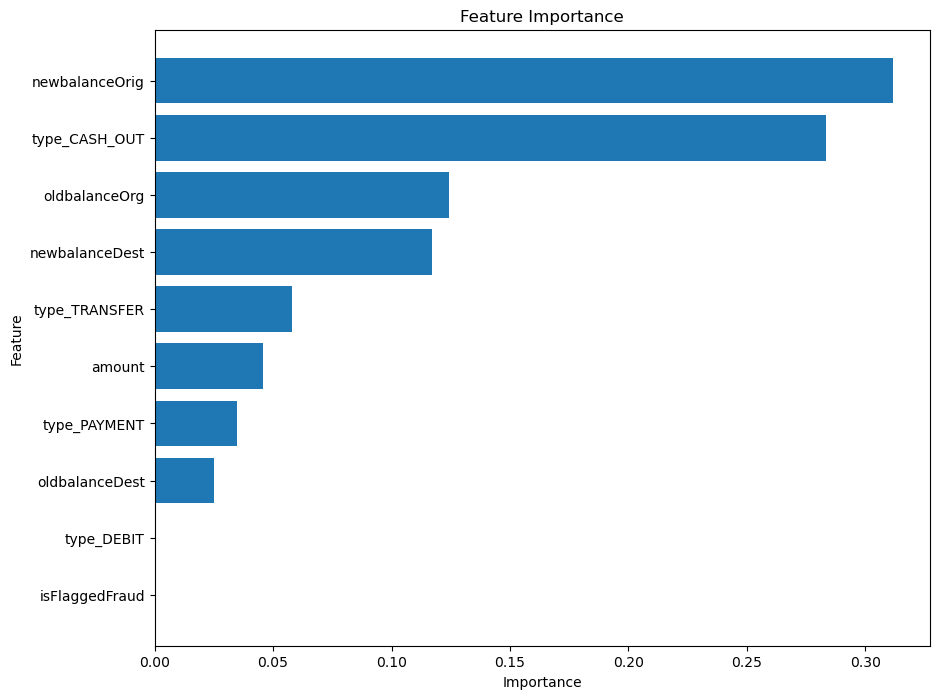

In [8]:
#En el siguiente grafico se representa graficamente la cantidad de informacion que brinda cada variable al modelo 
importances = pipeline_xgb.named_steps['classifier'].feature_importances_
categorical_features = pipeline_xgb.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=variables_categoricas)
feature_names = np.concatenate([variables_numericas, categorical_features])
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=True)


plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()